# ENEM - Regressão

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb;
import os
import optuna
from sklearn.model_selection import train_test_split
from sklearn import metrics

np.random.seed(42)

### Carregando os dados

Primeiro, vamos desconsiderar dados que possuem zero ou `NaN` nas notas de alguma disciplina

In [204]:
from tqdm import tqdm

if not os.path.exists('../data/microdados_nao_nulos.csv'):
    df_iterator = pd.read_csv('../data/microdados_enem_2020.csv', chunksize=10000, encoding='ISO-8859-1', delimiter=';')

    for df in tqdm(df_iterator):
        nonull = df[
            (df['NU_NOTA_CN'].notnull()) & (df['NU_NOTA_CN'] != 0) &
            (df['NU_NOTA_MT'].notnull()) & (df['NU_NOTA_MT'] != 0) &
            (df['NU_NOTA_CH'].notnull()) & (df['NU_NOTA_CH'] != 0) & 
            (df['NU_NOTA_LC'].notnull()) & (df['NU_NOTA_LC'] != 0) & 
            (df['NU_NOTA_REDACAO'].notnull()) & (df['NU_NOTA_REDACAO'] != 0)]
        
        nonull.to_csv('../data/microdados_nao_nulos.csv', mode='a', header=False)
    

579it [02:27,  3.92it/s]


Vamos agora selecionar uma amostra de 10000 notas do nosso conjunto de dados

In [205]:
import pandas
import random

n = 2527394
s = 10000
filename = "../data/microdados_nao_nulos.csv"
skip = sorted(random.sample(range(n),n-s))
df = pandas.read_csv(filename, skiprows=skip, header=None, usecols=[i+1 for i in range(76)])
header = pd.read_csv('../data/microdados_enem_2020.csv', nrows=1, encoding='ISO-8859-1', delimiter=';').columns
df.columns = header

Separamos então nossos dados em um conjunto de treino (70% dos nossos dados) e um conjunto de teste (30% dos nossos dados)

In [207]:
# Separando os dados em teste e treino
p_train = 0.7
p_test = 1 - p_train

indices = np.random.randint(0, 10000, 10000)
df = df.iloc[indices, :]

train_df = df.iloc[:int(10000*p_train), :]
test_df = df.iloc[int(10000*p_test):, :]

In [208]:
# Selecionando algumas features de acordo com a correlação
features = [
    'NU_NOTA_CN',
    'NU_NOTA_CH',
    'NU_NOTA_LC',
    'NU_NOTA_REDACAO',
    'NU_NOTA_COMP1',
    'NU_NOTA_COMP2',
    'NU_NOTA_COMP3',
    'NU_NOTA_COMP4',
    'NU_NOTA_COMP5']
features_corr = [
    'NU_NOTA_MT',
    'NU_NOTA_CN',
    'NU_NOTA_CH',
    'NU_NOTA_LC',
    'NU_NOTA_REDACAO',
    'NU_NOTA_COMP1',
    'NU_NOTA_COMP2',
    'NU_NOTA_COMP3',
    'NU_NOTA_COMP4',
    'NU_NOTA_COMP5']

### Verificando a correlação dos dados

Vamos verificar a correlação que cada nota tem entre elas

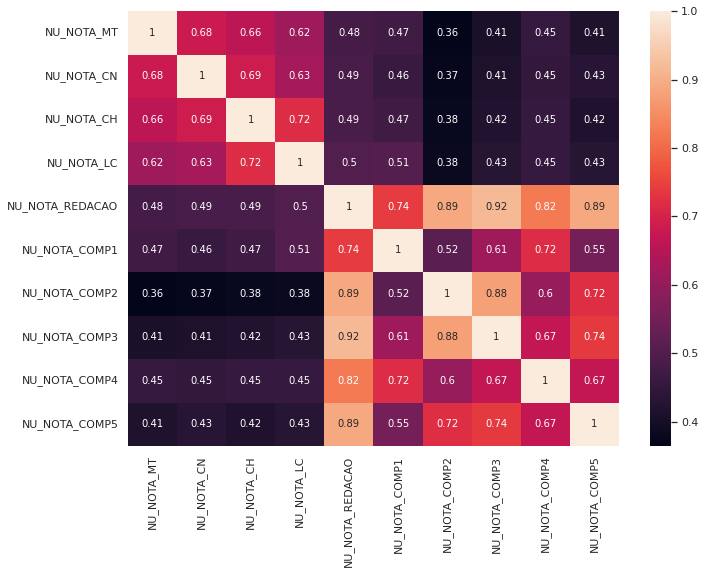

In [209]:
corr = train_df[features_corr].corr()
ax = plt.subplots(figsize=(11, 8))
sns.heatmap(corr,  annot=True, annot_kws={"size": 10});

### Verificando a distribuição de notas

Vamos agora ver como fica a distribuição de notas para cada disciplina dentro do nosso dataset

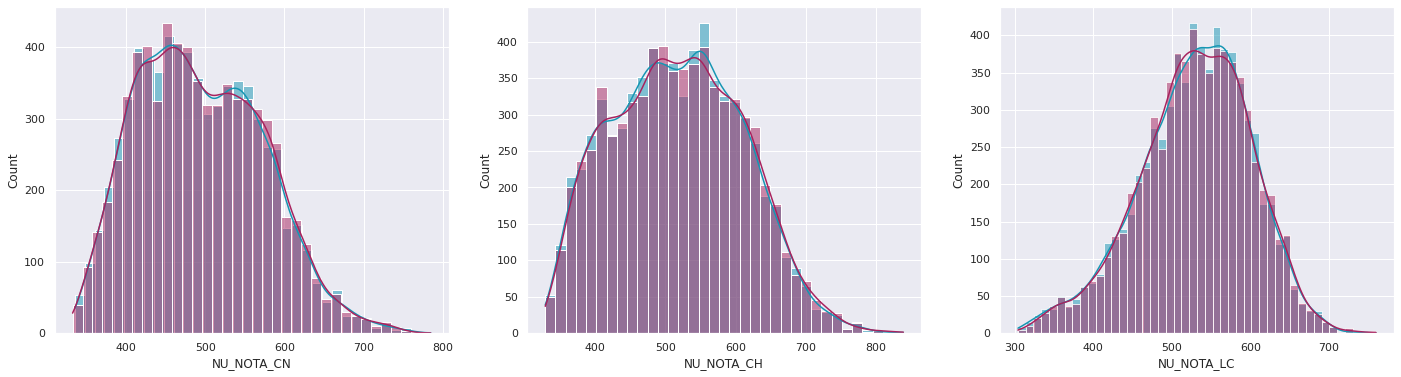

In [210]:
sns.set_theme()
fig, ax = plt.subplots(1, 3, figsize=(24, 6))
sns.histplot(data=train_df['NU_NOTA_CN'].fillna(0), ax=ax[0], kde=True, color="#1596b3");
sns.histplot(data=test_df['NU_NOTA_CN'].fillna(0), ax=ax[0], kde=True, color="#a8225e");

sns.histplot(data=train_df['NU_NOTA_CH'].fillna(0), ax=ax[1], kde=True, color="#1596b3");
sns.histplot(data=test_df['NU_NOTA_CH'].fillna(0), ax=ax[1], kde=True, color="#a8225e");

sns.histplot(data=train_df['NU_NOTA_LC'].fillna(0), ax=ax[2], kde=True, color="#1596b3");
sns.histplot(data=test_df['NU_NOTA_LC'].fillna(0), ax=ax[2], kde=True, color="#a8225e");

## Regressor

Vamos aplicar uma regressão e verificar se conseguimos predizer a nota de matemática basada nas demais notas.

### Transformando os dados

Inicialmente, nossos dados são compostos por notas entre 0 e ~1000. Vamos aplicar um `StandardScaler` para trazer esses valores mais perto da origem.

In [211]:
# Escolhe-se as notas de matemática
y_train = train_df['NU_NOTA_MT']
x_train = train_df[features]
x_test = test_df[features]
y_test = test_df['NU_NOTA_MT']

# Padronizando os dados
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()  
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [212]:
from sklearn.metrics import r2_score

def evaluate_regressor(regressor):
    regressor.fit(x_train, y_train);
    y_pred_test = regressor.predict(x_test);
    print('MAE:', metrics.mean_absolute_error(y_test, y_pred_test))
    print('MSE:', metrics.mean_squared_error(y_test, y_pred_test))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))
    print('R2:', r2_score(y_test, y_pred_test))

    results = pd.DataFrame([y_test.values, y_pred_test, np.abs(y_pred_test - y_test) > np.std(y_pred_test - y_test)]).transpose()
    results.columns = ['true', 'pred', 'in std']

    ax = sns.regplot(x=y_test, y=y_pred_test, scatter=False, color='#1596b3')
    sns.scatterplot(data=results, x='true', y='pred', ax=ax, hue='in std');

### Testando os regressores

Vamos agora testar alguns regressores diferentes, conferindo os valores de MAE, MSE e RMSE

#### Random forest

Random Forest
MAE: 51.67400031428572
MSE: 4364.399542873445
RMSE: 66.06360225474724
R2: 0.6707902718728749


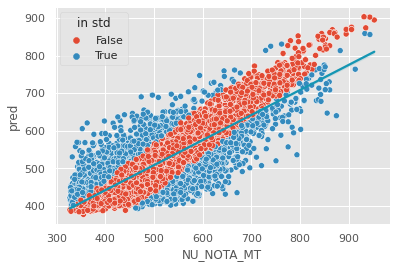

In [226]:
# Treina-se um modelo RandomForest
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor( 
           criterion='absolute_error', 
           max_depth=8,
           max_leaf_nodes=None,
           min_samples_leaf=1,
           min_samples_split=2,
           min_weight_fraction_leaf=0.0,
           n_estimators= 500,
           n_jobs=-1,
           random_state=0,
           verbose=0,
           warm_start=False
)

print('Random Forest')
evaluate_regressor(regressor)

#### XGBoost Regressor

Esse é um regressor um pouco mais sofisticado, baseado em árvore

XGBoost Regressor
MAE: 16.63618892037528
MSE: 1346.9348656096631
RMSE: 36.70061124299789
R2: 0.898399755440273


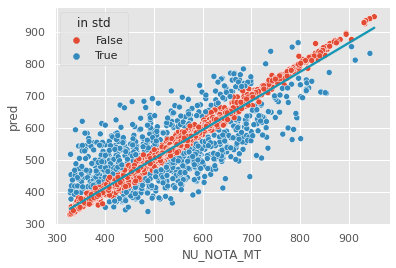

In [225]:
from xgboost import XGBRegressor

regressor = XGBRegressor(
    n_estimators=1000,
    max_depth=7,
    eta=0.1,
    subsample=0.7,
    colsample_bytree=0.8
)

print('XGBoost Regressor')
evaluate_regressor(regressor)

O resultado com esse regressor parece promissor! Vamos otimizar seus hiperparâmetros com a biblioteca `optuna`

### Otimizando os hiperparâmetros

In [221]:
from sklearn.metrics import mean_squared_error
import joblib
import os

def objective(trial):
    
    param = {
        # 'tree_method': 'gpu_hist',
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.009,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'n_estimators': 4000,
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17,20]),
        'random_state': trial.suggest_categorical('random_state', [24, 48,2020]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
    }
    model = xgb.XGBRegressor(**param)  
    
    model.fit(x_train, y_train , eval_set=[(x_test, y_test)], early_stopping_rounds=100, verbose=False)
    
    preds = model.predict(x_test)
    
    rmse = mean_squared_error(y_test, preds, squared=False)
    
    return rmse
if not os.path.exists('study.pkl'):
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)
    joblib.dump(study, 'study.pkl')
else:
    study = joblib.load('study.pkl')


Agora, vamos visualizar um pouco do processo de otimização de hiperparâmetros

<AxesSubplot:title={'center':'Optimization History Plot'}, xlabel='#Trials', ylabel='Objective Value'>

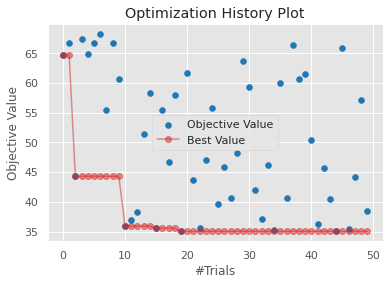

In [222]:
%%capture --no-display
optuna.visualization.matplotlib.plot_optimization_history(study);

In [223]:
print("Best trial until now:")
print(" Value: ", study.best_trial.value)
print(" Params: ")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

Best trial until now:
 Value:  35.02428584224759
 Params: 
    lambda: 0.08161815727397106
    alpha: 0.003109668305639839
    colsample_bytree: 0.7
    subsample: 0.8
    learning_rate: 0.02
    max_depth: 9
    random_state: 24
    min_child_weight: 1


MAE: 13.592333980015345
MSE: 1226.7393789363607
RMSE: 35.02483945625391
R2: 0.9074661855645354


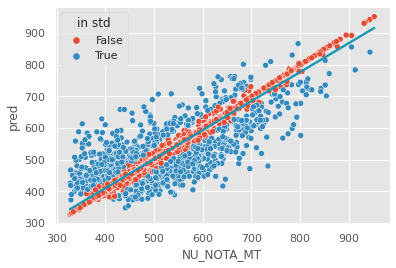

In [224]:
regressor = XGBRegressor(n_estimators = 4000, **study.best_trial.params)

evaluate_regressor(regressor)